In [18]:
import sys, os
sys.path.append(os.path.abspath(".."))


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from src.dataset import SpeechDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

if torch.cuda.is_available():
    print("GPU utilisé :", torch.cuda.get_device_name(0))
else:
    print("Pas de GPU détecté")


GPU utilisé : NVIDIA GeForce RTX 4050 Laptop GPU


In [20]:
dataset = SpeechDataset("../data/processed/melspec", feature_type="melspec")
len(dataset)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [21]:
class CNNEmotion(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = CNNEmotion().to(device)
model


CNNEmotion(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [25]:
epochs = 20
loss_history = []

for epoch in range(epochs):
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total += loss.item()

    loss_history.append(total)
    print(f"Epoch : {epoch+1} | Loss : {total}")


Epoch : 1 | Loss : 1965.6193794831634
Epoch : 2 | Loss : 1594.8939326107502
Epoch : 3 | Loss : 1330.3689322844148
Epoch : 4 | Loss : 1113.1279651075602
Epoch : 5 | Loss : 955.5903263390064
Epoch : 6 | Loss : 811.1281238123775
Epoch : 7 | Loss : 709.9808438974433
Epoch : 8 | Loss : 625.9590529071284
Epoch : 9 | Loss : 569.8872905584722
Epoch : 10 | Loss : 522.8704248276772
Epoch : 11 | Loss : 450.73380630475003
Epoch : 12 | Loss : 443.08885237647337
Epoch : 13 | Loss : 397.0028656313225
Epoch : 14 | Loss : 370.31115121612675
Epoch : 15 | Loss : 355.0377691740068
Epoch : 16 | Loss : 309.90842117965803
Epoch : 17 | Loss : 328.0031905811811
Epoch : 18 | Loss : 310.1784796181928
Epoch : 19 | Loss : 287.03774179568427
Epoch : 20 | Loss : 289.1806363089854


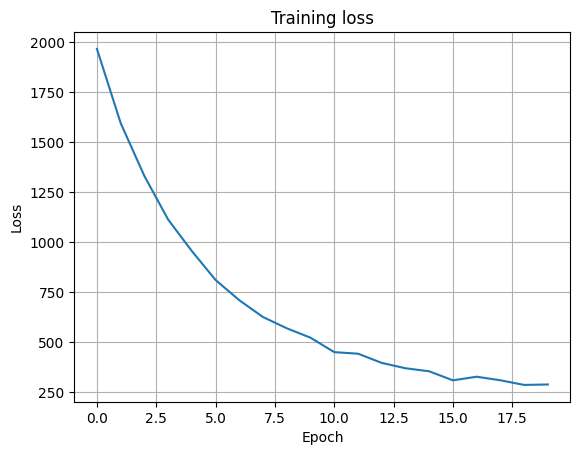

In [26]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [27]:
torch.save(model.state_dict(), "cnn_baseline.pth")


## **Commentaires**

- La perte diminue correctement, donc le modèle apprend.
- Le plateau en fin d’entraînement montre que l’architecture est un peu trop simple.
